# What is neural style transfer?

Neural style treansfer is a technique where there are 3 images. **Content** image, **Style** image  and **input** image. We want to retain content of the content image into our input image and we want to retain style of the style image into our input image.

For this we define 2 losses : 
The principle of neural style transfer is to define two distance functions, one that describes how different the content of two images are , $L_{content}$, and one that describes the difference between two images in terms of their style, $L_{style}$. Then, given three images, a desired style image, a desired content image, and the input image (initialized with the content image), we try to transform the input image to minimize the content distance with the content image and its style distance with the style image. 


In summary, we’ll take the base input image, a content image that we want to match, and the style image that we want to match. We’ll transform the base input image by minimizing the content and style distances (losses) with backpropagation, creating an image that matches the content of the content image and the style of the style image. 

In [0]:
import os

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

TensorFlow 1.x selected.


In [0]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
# Turn On TPU!!
#resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
#tf.tpu.experimental.initialize_tpu_system(resolver)
#strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [0]:
# Set up some global values here
content_path = '/content/drive/My Drive/Deep Learning Dataset/Images_styleTransferReview_TVCG/Content/1.png'
style_path = '/content/drive/My Drive/Deep Learning Dataset/Images_styleTransferReview_TVCG/Style/5.png'

# Input Visualization

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [0]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

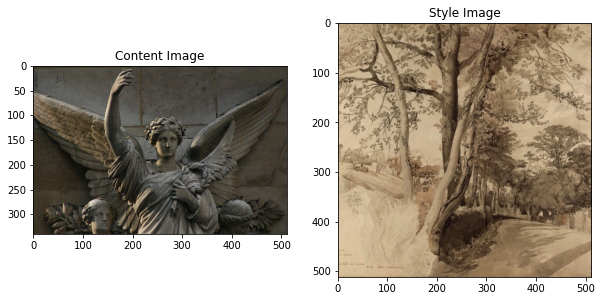

In [0]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

# Training

In [0]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

# Defining Content and Style Loss

we define content and style losses

In [0]:
# Content loss layers
content_layers = ['block5_conv2'] 

# Style loss layers 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def get_model():
  '''
  creates style transfer vgg19 model instance and returns it
  '''
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [0]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [0]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [0]:
def get_feature_representations(model, content_path, style_path):
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

  style_weight, content_weight = loss_weights

  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [0]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
 e. 
  runtime = []
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  k = 0
  start_time = time.time()
  for i in range(num_iterations):
    print('--------Iteration :',k,'-----------')
    k=k+1
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
      
    print('loss for this iteration :',loss, ' End time : ', end_time-start_time)
    runtime.append(end_time-start_time)

    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])

  return best_img, best_loss, cfg, runtime

In [0]:
style_path

'/content/drive/My Drive/Deep Learning Dataset/Images_styleTransferReview_TVCG/Style/5.png'

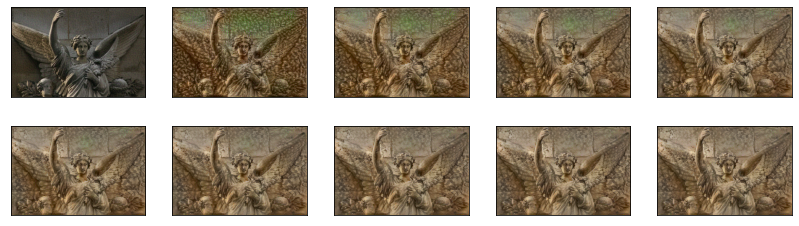

In [0]:
best, best_loss , cfg, runtime = run_style_transfer(content_path, style_path, num_iterations=1000)

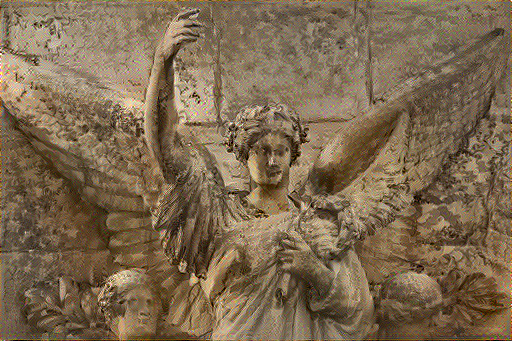

In [0]:
Image.fromarray(best)

In [0]:
#from google.colab import files
#files.download('wave_turtle.png')

In [0]:
filter_model = cfg['model']

In [0]:
runtime

[0.4712693691253662,
 0.16852641105651855,
 0.2602560520172119,
 0.3488883972167969,
 0.4353446960449219,
 0.5244424343109131,
 0.6116681098937988,
 0.6980910301208496,
 0.7894909381866455,
 0.8771140575408936,
 0.9679596424102783,
 1.063014268875122,
 1.147792100906372,
 1.2350823879241943,
 1.3258440494537354,
 1.4123737812042236,
 1.4991848468780518,
 1.5892090797424316,
 1.6730616092681885,
 1.7625782489776611,
 1.8493270874023438,
 1.9359142780303955,
 2.025202751159668,
 2.1110658645629883,
 2.2025504112243652,
 2.2908122539520264,
 2.375539779663086,
 2.459944486618042,
 2.544569969177246,
 2.6327500343322754,
 2.7171034812927246,
 2.802823781967163,
 2.8939714431762695,
 2.9767072200775146,
 3.0596001148223877,
 3.1460318565368652,
 3.229783058166504,
 3.3131024837493896,
 3.4004297256469727,
 3.4845199584960938,
 3.567601203918457,
 3.6549811363220215,
 3.7368276119232178,
 3.820930242538452,
 3.9093849658966064,
 3.9930315017700195,
 4.0766823291778564,
 4.162775039672852,
 4

# Output Visualization

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

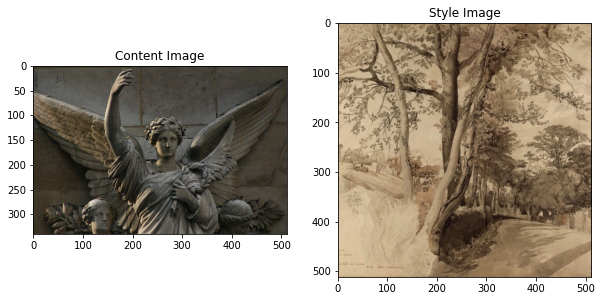

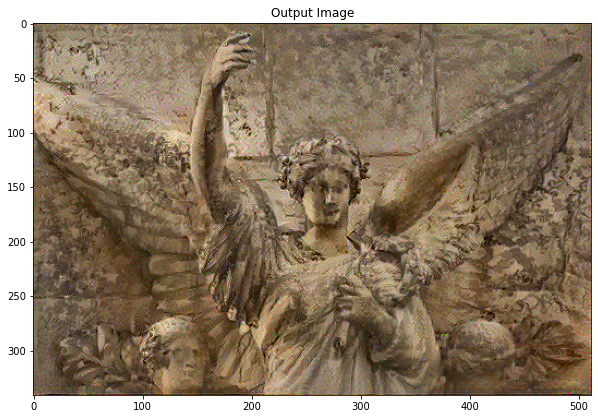

In [0]:
show_results(best, content_path, style_path)

In [0]:
cfg

{'content_features': [<tf.Tensor: id=716, shape=(21, 32, 512), dtype=float32, numpy=
  array([[[  0.       ,  81.033195 ,  97.998695 , ...,   0.       ,
             0.       ,  60.970165 ],
          [  0.       ,  49.67681  ,   0.       , ...,   0.       ,
             0.       ,   8.756072 ],
          [  0.       ,   7.8993216,   0.       , ...,   0.       ,
             6.163788 ,   0.       ],
          ...,
          [ 36.965366 ,   0.       ,   1.3749031, ...,   0.       ,
            37.008263 ,   0.       ],
          [ 33.63912  ,   0.       ,  10.304554 , ...,   0.       ,
            36.367798 ,   0.       ],
          [  3.91886  ,   0.       ,   1.8283561, ...,   0.       ,
            29.894196 ,   2.7571404]],
  
         [[  0.       , 103.32066  , 101.37957  , ...,   0.       ,
             0.       ,  71.72544  ],
          [  0.       ,  55.022892 ,   0.       , ...,   0.       ,
             0.       ,  32.767704 ],
          [  0.       ,  41.993496 ,   0.       

In [0]:
filter_model.evaluate?

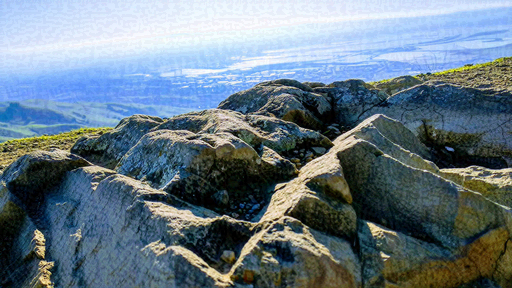

Iteration: 0
Total loss: 2.3621e+08, style loss: 2.3621e+08, content loss: 0.0000e+00, time: 0.0557s
--------Iteration : 1 -----------
loss for this iteration : tf.Tensor(110171400.0, shape=(), dtype=float32)  End time :  0.18351030349731445
--------Iteration : 2 -----------
loss for this iteration : tf.Tensor(78250190.0, shape=(), dtype=float32)  End time :  0.2951645851135254
--------Iteration : 3 -----------
loss for this iteration : tf.Tensor(64722988.0, shape=(), dtype=float32)  End time :  0.4038660526275635
--------Iteration : 4 -----------
loss for this iteration : tf.Tensor(56542564.0, shape=(), dtype=float32)  End time :  0.5103263854980469
--------Iteration : 5 -----------
loss for this iteration : tf.Tensor(51183676.0, shape=(), dtype=float32)  End time :  0.6164417266845703
--------Iteration : 6 -----------
loss for this iteration : tf.Tensor(47233668.0, shape=(), dtype=float32)  End time :  0.7321584224700928
--------Iteration : 7 -----------
loss for this iteration : tf.

KeyboardInterrupt: ignored

In [0]:
best1, best_loss1 , cfg1, runtime1 = run_style_transfer('/content/drive/My Drive/Photo/EFFECTS.jpg', style_path, num_iterations=2000)

In [0]:
best1

array([[[156, 151, 117],
        [135, 135, 129],
        [186, 185,  77],
        ...,
        [146, 152, 135],
        [143, 139, 135],
        [200, 161, 121]],

       [[113, 127, 130],
        [109, 138, 167],
        [119, 140, 175],
        ...,
        [167, 129, 144],
        [161, 147, 164],
        [175, 137, 119]],

       [[164, 121, 110],
        [139, 107, 130],
        [199, 176,  54],
        ...,
        [152, 159, 159],
        [165, 150, 135],
        [154, 174, 134]],

       ...,

       [[ 51,  16,  19],
        [ 99,  72,  64],
        [ 51,  47,  63],
        ...,
        [100,  76,  75],
        [125, 109,   5],
        [133,  96,   0]],

       [[106, 114,  61],
        [ 78,  82,  35],
        [102,  94,  73],
        ...,
        [ 88,  99,  62],
        [104,  86,  40],
        [134, 108,  37]],

       [[ 37,  59,  27],
        [125,  76,  86],
        [ 82,  57,  52],
        ...,
        [ 75,  77,  50],
        [152,  79,   0],
        [ 76,  73,   0]]

In [0]:
show_best